## Data606 - Capstone Project
```
Group H
Malav Patel, Kent Butler
Prof. Unal Sokaglu
```

This project is about performing time-series analysis on climate data analysis data.



# Research

### References

Some explanations of earth sciences statistics:
https://pjbartlein.github.io/REarthSysSci/ltms-and-anomalies.html

NOAA PSL NCEP-NCAR datasets:  https://psl.noaa.gov/data/gridded/data.ncep.reanalysis.html

NOAA PSL, other recognized data sources directory: https://psl.noaa.gov/data/help/othersources/

Global environmental policy timeline, https://www.boell.de/en/2022/05/28/international-environmental-policy-timeline

OECD convergence of policy, climate,and economy: https://www.oecd.org/

NASA climate time machine: https://climate.nasa.gov/interactives/climate-time-machine

### Factoids

* All of the plastic waste produced in the world in 2019 alone weighs as much as 35,000 Eiffel Towers – 353 million tons  - [*Organization for Economic Cooperation and Development (OECD)*](https://www.boell.de/en/2022/05/28/international-environmental-policy-timeline)



## Application Parameters

Note: algorithm tuning is done with declaration of the model.

In [ ]:
import pandas as pd
from datetime import datetime as dt
import datetime

In [ ]:
debug = True

DRIVE_PATH = "/content/drive/MyDrive/data606"

# Set the location of this script in GDrive
SCRIPT_PATH = DRIVE_PATH + "/src/"

# Root Path of the data on the cloud drive
DATA_ROOT = DRIVE_PATH + "/data/"

# Model to use
MODEL_NAME = "LSTMv2"

# Location of logged output prediction data
LOG_PATH = DATA_ROOT + "/preds/"

# Journal file
JOURNAL_LOG = SCRIPT_PATH + "cv-results.csv"

# Number of samples to work with - will be split  into train/test
SAMPLE_SIZE = 5000

# Device to run on
run_on_device =  'cpu' # 'cuda'

# Start including data from this date
START_DATE =  pd.to_datetime(dt.fromisoformat('1950-01-01'))
# Stop including data after this date
END_DATE = pd.to_datetime(dt.fromisoformat('2015-12-01'))

---

**Model Configuration**

---

**Basic model params**

In [ ]:
# History lookback in network
INPUT_WINDOW = 30
# How far forward to predict
LABEL_WINDOW = 1
# Ratio of test data to train data - used for split
TEST_RATIO = 0.2
# 0..1 percent of data to use as validation
VALIDATION_RATIO = 0.1
# Num epochs
NUM_EPOCHS = 30

**Configure Predictions**

In [ ]:
# Label to predict
TARGET_LABEL = 'landSeaAvgTemp'

# Base dataset
TEMP_DATA = {'filename':'GlobalTemperatures.csv',
             'feature_map':{'LandAndOceanAverageTemperature':'landSeaAvgTemp'},
             'date_col':'dt'}
#TEMP_DATA = {'filename':'GlobalTemperatures.csv',
#              'feature_map':{'LandAverageTemperature':'landAvgTemp',	'LandMaxTemperature':'landMaxTemp',	'LandMinTemperature':'landMinTemp',	'LandAndOceanAverageTemperature':'landSeaAvgTemp'},
#               'date_col':'dt'}


# Datasets
CO2_DATA = {'filename':"atmospheric-co2.csv",
            'feature_map':{'Carbon Dioxide (ppm)':'co2', 'Seasonally Adjusted CO2 (ppm)':'co2_seas'},
            'date_map':{'Year':'year','Month':'month'}}

SEAICE_DATA = {'filename':"seaice.csv",
               'feature_map':{'     Extent':'ice_extent','    Missing':'ice_missing'},
               'date_map':{' Month':'month','Year':'year',' Day':'day'}}

WEATHER_DATA = {'filename':"finalDatasetWithRain.csv",
                'feature_map':{'air_x':'air_x','air_y':'air_y','uwnd':'uwnd'},
                'date_col':'time'}

VOLCANO_DATA = {'filename':'eruptions-conditioned.csv',
                'feature_map':{'vei':'volcanic_idx'},
                'date_map':{'start_year':'year','start_month':'month'}}

FOREST_DATA = {'filename':'WorldForestCover.csv',
               'feature_map':{'PctCover':'pct_forest_cover'},
               'date_map':{'Year':'year'}}

SUNSPOT_DATA = {'filename':'sunspotnumber.csv',
               'feature_map':{'suns_spot_number':'sunspot_num'},
               'date_map':{'year':'year'}}

POLICY_DATA = {'filename':'GlobalEnvPolicies.csv',
               'feature_map':{'EventRating':'policy_rate'},
               'date_col':'date'}

#GHG_DATA = {'filename':'greenhouse_gas_inventory_data.csv',
#            'feature_map':{''},
#            'date_map':{'Year':'year'}}
#ALL_DATASETS = []
#ALL_DATASETS = [SUNSPOT_DATA]
ALL_DATASETS = [FOREST_DATA]
#ALL_DATASETS = [CO2_DATA, SEAICE_DATA]
#ALL_DATASETS = [CO2_DATA, SEAICE_DATA, WEATHER_DATA]
#ALL_DATASETS = [CO2_DATA, SEAICE_DATA, VOLCANO_DATA]
#ALL_DATASETS = [CO2_DATA, SEAICE_DATA, WEATHER_DATA, VOLCANO_DATA]
#ALL_DATASETS = [CO2_DATA, SEAICE_DATA, WEATHER_DATA, VOLCANO_DATA, FOREST_DATA]
#ALL_DATASETS = [CO2_DATA, SEAICE_DATA, WEATHER_DATA, VOLCANO_DATA, FOREST_DATA, SUNSPOT_DATA]
#ALL_DATASETS = [VOLCANO_DATA, FOREST_DATA, SUNSPOT_DATA]
#ALL_DATASETS = [VOLCANO_DATA, FOREST_DATA, SUNSPOT_DATA, CO2_DATA]
#ALL_DATASETS = [VOLCANO_DATA, FOREST_DATA, SUNSPOT_DATA, CO2_DATA, SEAICE_DATA]
#ALL_DATASETS = [CO2_DATA, SEAICE_DATA, VOLCANO_DATA, FOREST_DATA, SUNSPOT_DATA]

#ALL_DATASETS = [POLICY_DATA,CO2_DATA]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd $SCRIPT_PATH

/content/drive/MyDrive/data606/src


In [ ]:
# Load util class
%run -i "./ProjectUtil.ipynb"

In [ ]:
# Load util class
#%run -i "./WindowGenerator.ipynb"

# Data Load

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns; sns.set()
plt.rcParams["figure.figsize"] = (10,6)
import warnings

In [ ]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
%matplotlib inline

---

**Initial Data Load**

---

In [ ]:
# Load util class
%run -i "./Dataset_Merger.ipynb"

In [ ]:
# Declare a merger compatible with our source data and our target dataset we want to merge into
merger = Dataset_Merger(data_path=DATA_ROOT, start_date=START_DATE, end_date=END_DATE, debug=True)

------------------------------------------
 ###  ============================================================
  Loading data/content/drive/MyDrive/data606/data/GlobalTemperatures.csv

 ### Defaulting df_aggr to reference df
------------------------------------------
 ### Renaming columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3192 non-null   object 
 1   LandAverageTemperature                     3180 non-null   float64
 2   LandAverageTemperatureUncertainty          3180 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature                         1992 non-null   float64
 6   LandMinTemperatureUncert

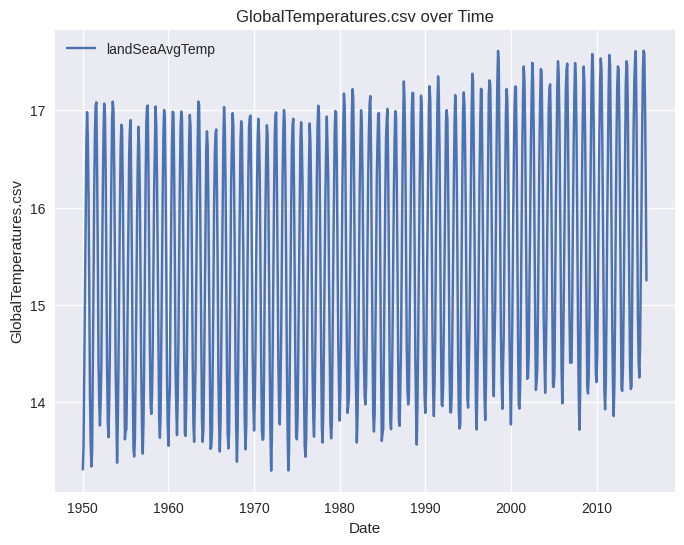

In [ ]:
# Start by merging initial dataset
df_merge = merger.merge_dataset(TEMP_DATA['filename'],
                                TEMP_DATA['feature_map'],
                                 date_col=TEMP_DATA['date_col'],
                                 add_cyclic=True)

In [ ]:
print(assess_na(df_merge))

  _date_  day year month landSeaAvgTemp month-sin month-cos
0    0.0  0.0  0.0   0.0            0.0       0.0       0.0


---

**Merge Additional Data**

---

------------------------------------------
 ###  ============================================================
  Loading data/content/drive/MyDrive/data606/data/WorldForestCover.csv

------------------------------------------
 ### Renaming columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860 entries, 0 to 859
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              860 non-null    int64  
 1   Country           860 non-null    object 
 2   TotalArea         860 non-null    float64
 3   CoverArea         860 non-null    int64  
 4   pct_forest_cover  860 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 33.7+ KB
------------------------------------------
 ### preprocess_dates with date_col: None
------------------------------------------
 ### Creating std date columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860 entries, 0 to 859
Data columns (total 8 colu

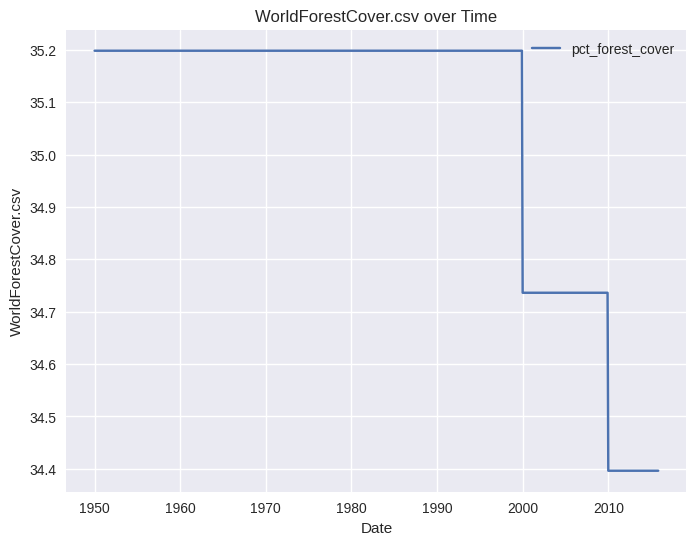

  _date_  day year month landSeaAvgTemp month-sin month-cos pct_forest_cover
0    0.0  0.0  0.0   0.0            0.0       0.0       0.0              0.0


In [ ]:
for dataset in ALL_DATASETS:
  if ('date_map' in dataset):
    df_merge = merger.merge_dataset(dataset['filename'],
                                    feature_map=dataset['feature_map'],
                                    df_aggr=df_merge,
                                    date_map=dataset['date_map'])
  else:
    df_merge = merger.merge_dataset(dataset['filename'],
                                feature_map=dataset['feature_map'],
                                df_aggr=df_merge,
                                date_col=dataset['date_col'])
  print(assess_na(df_merge))

In [ ]:
df_merge

,_date_,day,year,month,landSeaAvgTemp,month-sin,month-cos,pct_forest_cover
0,1950-01-01,1.0,1950,1,13.311,0.500000,8.660254e-01,35.198512
1,1950-02-01,1.0,1950,2,13.554,0.866025,5.000000e-01,35.198512
2,1950-03-01,1.0,1950,3,14.296,1.000000,6.123234e-17,35.198512
3,1950-04-01,1.0,1950,4,15.093,0.866025,-5.000000e-01,35.198512
4,1950-05-01,1.0,1950,5,16.033,0.500000,-8.660254e-01,35.198512
...,...,...,...,...,...,...,...,...
786,2015-07-01,1.0,2015,7,17.611,-0.500000,-8.660254e-01,34.396326
787,2015-08-01,1.0,2015,8,17.589,-0.866025,-5.000000e-01,34.396326
788,2015-09-01,1.0,2015,9,17.049,-1.000000,-1.836970e-16,34.396326
789,2015-10-01,1.0,2015,10,16.290,-0.866025,5.000000e-01,34.396326


---

**Assess correlations**

---

In [ ]:
# Assess correlations between all data columns
df_corr = df_merge.corr()

In [ ]:
# Identify the columns which have medium to strong correlation with target
df_corr_cols = df_corr[df_corr[TARGET_LABEL] > 0.5]

In [ ]:
# Drop the target from the correlation results in case we want to use this reduced set
#    in place of the full set
df_corr_cols = df_corr_cols.drop(columns=[])

In [ ]:
# Extract just the column names
corr_cols = df_corr_cols.index.values

In [ ]:
if debug:
  print(corr_cols)

['landSeaAvgTemp']


Text(0.5, 1.0, 'Heatmap of correlation among variables')

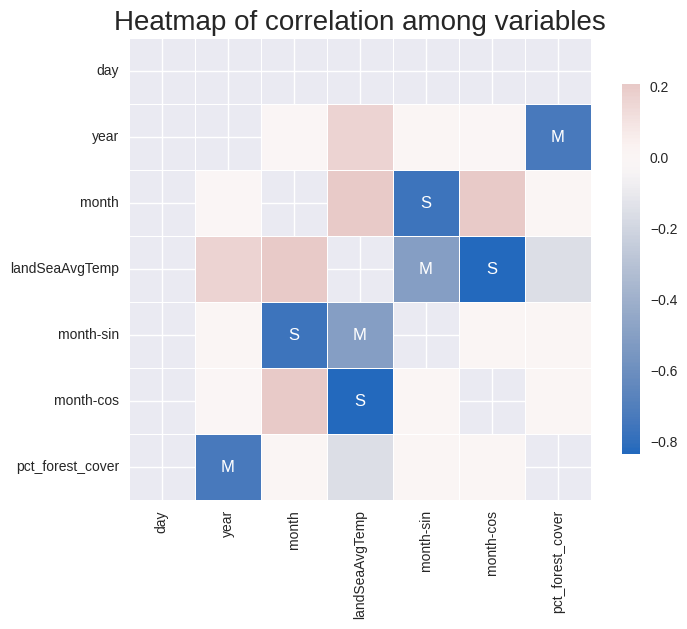

In [ ]:
# Add labels
labels = np.where(np.abs(df_corr) > 0.75, 'S',
                  np.where(np.abs(df_corr) > 0.5, 'M',
                           np.where(np.abs(df_corr) > 0.25, 'W', '')))
# Plot the matrix
plt.figure(figsize=(8,6))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt = '', linewidths = .5,
            cmap='vlag', cbar_kws={'shrink':0.8});
plt.title('Heatmap of correlation among variables', fontsize=20)

---

**Prepare for Modeling**

---

In [ ]:
# It's time to set date as index and remove from dataset
df_merge.set_index(merger.DATE_COL, inplace=True, drop=True)

In [ ]:
df_merge

,day,year,month,landSeaAvgTemp,month-sin,month-cos,pct_forest_cover
_date_,,,,,,,
1950-01-01,1.0,1950,1,13.311,0.500000,8.660254e-01,35.198512
1950-02-01,1.0,1950,2,13.554,0.866025,5.000000e-01,35.198512
1950-03-01,1.0,1950,3,14.296,1.000000,6.123234e-17,35.198512
1950-04-01,1.0,1950,4,15.093,0.866025,-5.000000e-01,35.198512
1950-05-01,1.0,1950,5,16.033,0.500000,-8.660254e-01,35.198512
...,...,...,...,...,...,...,...
2015-07-01,1.0,2015,7,17.611,-0.500000,-8.660254e-01,34.396326
2015-08-01,1.0,2015,8,17.589,-0.866025,-5.000000e-01,34.396326
2015-09-01,1.0,2015,9,17.049,-1.000000,-1.836970e-16,34.396326


**Assess Periodicity**

```
# removed kendalltau analysis
# Replace with fft graph of major freqs?
```


**Resampling**

This is being performed during the dataset merging phase.

Ready for time series modeling.

---

**Data conversion for model**

---

**Extract labels**

Time series creates a supervised learning problem out of moving data.

**Dataset stats**

In [ ]:
NUM_FEATURES = len(df_merge.columns)

# Capture stats on number of non-metadata columns - so, exclude some stuff
#NET_NUM_FEATURES = len(set(df_merge.columns) - set(['year','month','day']))

In [ ]:
# Keep rows aside for post validation?
TOTAL_ROWS = df_merge.shape[0]
NUM_VALIDATION = math.floor(TOTAL_ROWS * VALIDATION_RATIO)
WORKING_ROWS = TOTAL_ROWS - NUM_VALIDATION

In [ ]:
# Split non-validation rows into train/test
NUM_TEST = math.floor(WORKING_ROWS * TEST_RATIO)
NUM_TRAIN = WORKING_ROWS - NUM_TEST

In [ ]:
print(f'Num features: {NUM_FEATURES}')
print(f'Total rows: {TOTAL_ROWS}')
print(f'Validation rows: {NUM_VALIDATION}')
print(f'Train rows: {NUM_TRAIN}')
print(f'Test rows: {NUM_TEST}')

Num features: 7
Total rows: 791
Validation rows: 79
Train rows: 570
Test rows: 142


**Split into Train/Test**

In [ ]:
df_train = df_merge.iloc[:NUM_TRAIN, :]
df_val = df_merge.iloc[NUM_TRAIN:NUM_TRAIN+NUM_VALIDATION, :]
df_test = df_merge.iloc[NUM_TRAIN+NUM_VALIDATION:, :]

In [ ]:
y_train = df_train[TARGET_LABEL]
y_val = df_val[TARGET_LABEL]
y_test = df_test[TARGET_LABEL]

In [ ]:
if debug:
  print(f'df_train: {df_train.shape}')
  print(f'y_train: {y_train.shape}')
  print(f'df_test: {df_test.shape}')
  print(f'y_test: {y_test.shape}')
  print(f'df_val: {df_val.shape}')
  print(f'y_val: {y_val.shape}')

df_train: (570, 7)
y_train: (570,)
df_test: (142, 7)
y_test: (142,)
df_val: (79, 7)
y_val: (79,)


**Scale data**

Doing this **after** the split means that training data doesn't get unfair advantage of looking ahead into the 'future' during test & validation.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer,  QuantileTransformer, Normalizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import tensorflow as tf


In [ ]:
# Create small pipeline for numerical features
numeric_pipeline = Pipeline(steps = [('impute', SimpleImputer(strategy='mean')),
                                    ('scale', MinMaxScaler())])

In [ ]:
# get names of numerical features
con_lst = df_train.select_dtypes(include='number').columns.to_list()

In [ ]:
# Transformer for applying Pipelines
column_transformer = ColumnTransformer(transformers = [('number', numeric_pipeline, con_lst)])

In [ ]:
# Transform data features
X_train_tx = column_transformer.fit_transform(df_train)
X_test_tx = column_transformer.transform(df_test)
X_val_tx = column_transformer.transform(df_val)
X_train_tx.shape, X_test_tx.shape, X_val_tx.shape

((570, 7), (142, 7), (79, 7))

In [ ]:
# Transform labels
label_scaler = MinMaxScaler()
y_train_tx = label_scaler.fit_transform(y_train.values.reshape(-1, 1))

In [ ]:
# Slice labels - we cannot predict anything inside the first INPUT_WINDOW
y_train_tx = y_train_tx[INPUT_WINDOW:]

In [ ]:
if debug:
  print(f'X_train_tx {X_train_tx.shape}: {X_train_tx[0]}')
  print(f'y_train_tx {y_train_tx.shape}: {y_train_tx[0]}')

X_train_tx (570, 7): [0.         0.         0.         0.00318862 0.75       0.9330127
 0.        ]
y_train_tx (540, 1): [0.92469953]


**Extract X and y**

Normally we would do this by explicitly extracting data from our df.

However for a time series, we're going to create many small supervised learning sets, so a set of X and y pairs.

We should end up with data in a shape ready for batched network input:

`batches X time_steps X features`



In [ ]:
#windowing = TfWindowGenerator(input_width=INPUT_WINDOW,
#                              label_width=LABEL_WINDOW,
#                              shift=LABEL_WINDOW,
#                              label_columns=[TARGET_LABEL])

In [ ]:
# Pull X and y out of Training data
#X, y = windowing.generate(df_train)

In [ ]:
# testing more direct extraction
#X = np.asarray(df.drop(columns=[TARGET_LABEL]))
#X = np.asarray(df)

In [ ]:
if debug:
  print(f'X_train_tx: {X_train_tx.shape}')
  print(f'y_train_tx: {y_train_tx.shape}')

X_train_tx: (570, 7)
y_train_tx: (540, 1)


---

**Modeling**

---

In [ ]:
# These are the features we are going to be modeling
COLS = list(df_merge.columns)

**Slice into Batches**

In [ ]:
#ds = windowing.make_dataset(X, y)

In [ ]:
# Use tensorflow util to batch the timeseries
#   note that targets assume first label starts at 0 (vs. targets[INPUT_WINDOW])
ds = tf.keras.utils.timeseries_dataset_from_array(
    data=X_train_tx,
    targets=y_train_tx,
    batch_size=INPUT_WINDOW*2,
    sequence_length=INPUT_WINDOW )

**Prep GPU**

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


---

**Build and Train**

---

**Build model**

In [ ]:
# Load model class
%run -i "./Model_LSTMv2.ipynb"

In [ ]:
model = ModelLSTMv2(window_size=INPUT_WINDOW, num_epochs=NUM_EPOCHS, debug=True)

### Building ModelLSTMv2::


**Train model**

In [ ]:
#model.train(X, y, NUM_FEATURES)
model_history = model.train(dataset=ds, num_features=NUM_FEATURES)

Epoch 1/30
9/9 [==============================] - 24s 805ms/step - loss: 0.6059
Epoch 2/30
9/9 [==============================] - 6s 644ms/step - loss: 0.3432
Epoch 3/30
9/9 [==============================] - 6s 617ms/step - loss: 0.2737
Epoch 4/30
9/9 [==============================] - 9s 1s/step - loss: 0.2642
Epoch 5/30
9/9 [==============================] - 6s 648ms/step - loss: 0.2462
Epoch 6/30
9/9 [==============================] - 8s 876ms/step - loss: 0.2252
Epoch 7/30
9/9 [==============================] - 6s 614ms/step - loss: 0.1271
Epoch 8/30
9/9 [==============================] - 8s 955ms/step - loss: 0.0787
Epoch 9/30
9/9 [==============================] - 6s 662ms/step - loss: 0.0751


KeyboardInterrupt: ignored

In [ ]:
# Capture stat
num_epochs = len(model_history.history['loss'])

**Test Predictions**

In [ ]:
num_predictions = y_test.shape[0]-INPUT_WINDOW-LABEL_WINDOW
print(f'Num Exp. Predictions: {num_predictions} == {y_test.shape[0]} - {INPUT_WINDOW}')

preds = []
pred_dates = []
y_test_vals = []

In [ ]:
for p in range(num_predictions):
  print(f'Pred range: x_test_tx[{p}:{p+INPUT_WINDOW}]')
  X_pred = X_test_tx[p:p+INPUT_WINDOW,:].reshape(-1, INPUT_WINDOW, NUM_FEATURES)
  label_index = p+INPUT_WINDOW+LABEL_WINDOW-1
  print(f'Exp output: y_test[{label_index}]')
  print(f'Pred date: {df_test.index[label_index]}')
  y_test_vals.append(y_test[label_index])
  # Predict
  pred = model.predict(X_pred)
  print(type(pred))
  print(pred.shape)
  # Scale and save
  val = label_scaler.inverse_transform(pred)
  preds.append(label_scaler.inverse_transform(pred))
  pred_dates.append(df_test.index[label_index].strftime('%Y-%m-%d'))


In [ ]:
preds = np.array(preds).reshape(num_predictions)

**Analyze results**

In [ ]:
df_results = pd.DataFrame({'y_test': y_test_vals,
                          'preds': preds,
                           'pred_dates':pred_dates},
                           index=[i+1 for i in range(num_predictions)])

In [ ]:
df_results

In [ ]:
df_results.index
df_results.columns

In [ ]:
df_results.set_index('pred_dates', drop=False, inplace=True)



In [ ]:
df_results.iloc[0]

In [ ]:
# Plot results
# max points - default to full set
MAX_PTS=df_results.shape[0]
TICK_SPACING=6
fig, ax = plt.subplots(figsize=(12,4), layout="constrained")
sns.lineplot(data=df_results[:MAX_PTS], ax=ax)
ax.set_xticks(df_results.index[:MAX_PTS], labels=pred_dates[:MAX_PTS], rotation=90)
ax.xaxis.set_major_locator(plticker.MultipleLocator(TICK_SPACING))
plt.xlabel('Time steps')
plt.ylabel('Temp in degrees C')
plt.legend(('Test','Predicted'))

**Error Calculations**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# Calculate MAPE
m = tf.keras.metrics.MeanAbsolutePercentageError()
m.update_state(y_test_vals, preds)

In [ ]:
mse = mean_squared_error(y_test_vals, preds)
mae = mean_absolute_error(y_test_vals, preds)
mape = m.result().numpy()/100  # adjust Keras output to match scikit
from sklearn.metrics import mean_absolute_percentage_error
sk_mape = mean_absolute_percentage_error(y_test_vals, preds)

In [ ]:
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'SKMAPE: {sk_mape}')

**Journal entry**

In [ ]:
import csv

In [ ]:
def current_time_ms():
  return dt.now().microsecond

In [ ]:
serial = current_time_ms()

In [ ]:
# write pred results out
df_results.to_csv(LOG_PATH +  f'model-preds-{serial}.csv', index_label='index')

In [ ]:
# Save model
model.save_model(LOG_PATH, serial)

In [ ]:
with open(JOURNAL_LOG, 'a') as csvfile:
  writer = csv.writer(csvfile)
  #writer.writerow(['DateTime','Serial','Model','TargetLabel','NumFeatures','WindowSize','TestPct','NumEpochs','MSE','MAE','MAPE','SKMAPE','Columns'])
  writer.writerow([dt.today().strftime("%Y%m%d-%H%M"),serial,MODEL_NAME,TARGET_LABEL,NUM_FEATURES,INPUT_WINDOW,TEST_RATIO,num_epochs,mse,mae,mape,sk_mape,COLS])